# [엘리스] SKHy2 가이드 프로젝트

## Transformer를 활용한 Data Center Storage Fail 예측 모델 학습, 검증 및 시각화 Part 2

### 강의 복습
강의자료 : Transformer 및 시계열 표상 학습 기반의 Data Center Storage Fail 예측

- `Anomaly Detection`: 일부 기간 데이터를 입력으로 하여 해당 상황의 정상/비정상 여부를 탐지
- `Transformer`: Transformer는 Sequence를 입력으로 받아 sequenc를 출력하는 구조이므로, 시계열 과업에도 적용 가능
- `Representation learning` : 시계열의 의미 있는 정보를 더 쉽게 추출할 수 있도록 고차원의 raw data를 저 차원 공간에 mapping하는 것을 목표, 비지도 학습 방식으로 해당 데이터의 representation을 학습하고, 이를 downstreamtask에서 활용하는 방식

<img src="../image/AD01.png" width="800">

### 실습 요약

1. 본 실습에서는 Transformer를 활용한 representation learning 모델인 TS2Vec을 활용하여 시계열 이상탐지를 수행합니다.
2. Unlabeled data로 부터 Positive / Negative pair를 구축하여 contrastive learning을 통해 pre-training을 수행합니다.
3. 이상탐지 과업을 수행하도록 fine-tuning을 진행합니다.
4. 해당 모델에 대한 전체적인 구조는 강의자료 17 page에서 확인하실 수 있습니다.

[Yue, Zhihan, et al. "Ts2vec: Towards universal representation of time series." Proceedings of the AAAI Conference on Artificial Intelligence. Vol. 36. No. 8. 2022.](https://ojs.aaai.org/index.php/AAAI/article/view/20881)

<img src="../image/ts2vec01.png" width="600">

---

### STEP 0. 환경 구축하기

- 필요한 library들을 import 합니다.

In [1]:
# github에서 데이터 불러오기
# %cd ../
# !git clone https://github.com/yuezhihan/ts2vec.git
# %cd Elice_SK_Guided_PJT/src/ts2vec
%cd ../ts2vec

/tf/dsba/external_lecture/Elice_SK_Guided_PJT/src/ts2vec


In [2]:
import os
import sys
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta
import dateutil
import math
from sklearn.metrics import confusion_matrix, precision_score, recall_score, fbeta_score
from sklearn.model_selection import KFold

import torch
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.nn as nn

from models import TSEncoder
from models.losses import hierarchical_contrastive_loss
from utils import init_dl_program, name_with_datetime, pkl_save, data_dropout
from utils import take_per_row, split_with_nan, centerize_vary_length_series, torch_pad_nan

import warnings
warnings.filterwarnings("ignore")

#check torch version & device
print ("Python version:[%s]."%(sys.version))
print ("PyTorch version:[%s]."%(torch.__version__))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = init_dl_program(1, seed=42, max_threads=None)
print ("device:[%s]."%(device)) # device에 cuda:0가 프린트 된다면 GPU를 사용하는 상태입니다

Python version:[3.6.9 (default, Dec  8 2021, 21:08:43) 
[GCC 8.4.0]].
PyTorch version:[1.7.1].
device:[cuda:1].


In [3]:
# set random seed 
def set_seed(random_seed):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)  # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(random_seed)
    random.seed(random_seed)
    
random_seed = 42
set_seed(random_seed)

### STEP 1. 데이터 준비하기

지난 실습에서 전처리한 데이터셋을 불러옵니다.

- Dataset : train_preprocessed.pkl, valid_normal_preprocessed.pkl, valid_preprocessed.pkl 
- Info :
    - X 변수들은 SSD신뢰성에 영향을 줄 수 있는 SMART Attribute
    - Y는 특정 기준에 따라 분류된 Pass(0)/Fail(1)
    - X 변수는 18개

|Dataset|Length|#Normal|#Abnormal|#Serial|#Normal Serial|#Abnormal Serial|
|----|----|----|----|----|----|----|
|train|475,255|475,255|0|7,060|7,060|0|
|valid_normal|118,773|118,773|0|1,765|1,765|0|
|valid|218,874|118,773|100,101|3,281|1,765|1,516|

|Index|Features|Format|Description|
|----|----|----|:----|
|1|Serial Number|15|Serial Number|
|2|TIMESTAMP|2020.2.9  4:59:00 AM|Date-time reference|
|3|X1|EI83N072710203N8D|Equipment name|
|4|X2~18|27|Features|

In [4]:
# 데이터셋 불러오기
train_df = pd.read_pickle('../../data/train_preprocessed.pkl')
valid_normal_df = pd.read_pickle('../../data/valid_normal_preprocessed.pkl')
valid_df = pd.read_pickle('../../data/valid_preprocessed.pkl')

### STEP 3. 데이터셋 및 데이터로더 생성

각 serial 별로 input window를 구성하여 데이터셋, 데이터로더를 생성합니다.

<img src="../image/AD_process03.png" width="800">

In [5]:
class CustomDataset(Dataset):
    def __init__(self,
                 data: np.ndarray,
                 timestamps: np.ndarray,
                 serial_nums: np.ndarray,
                 interval: dict,
                 window_size: int,
                 slide_size: int = 1,
                 labels: np.ndarray = None):
        """
        Initialize a custom dataset
        :param data: 데이터 배열
        :param timestamps: 타임스탬프 배열
        :param serial_nums: 일련번호 배열
        :param interval: 시간 간격
        :param window_size: 윈도우 크기
        :param slide_size: 슬라이드 크기 (기본값 1)
        :param labels: 레이블 배열 (옵션)
        """
        self.ts = np.array(timestamps)
        self.serial_nums = serial_nums
        self.tag_values = np.array(data, dtype=np.float32)
        self.window_size = window_size
        self.with_label = labels is not None
        
        if self.with_label:
            self.labels = np.array(labels, dtype=np.float32)
        
        # 시간 간격 계산
        delta = timedelta(days=interval['day'], 
                          hours=interval['hour'],
                          minutes=interval['minute'],
                          seconds=interval['second'])
        
        # 유효한 인덱스 계산
        self.valid_idxs = []
        for L in range(0, len(self.ts) - window_size + 1, slide_size):
            R = L + window_size - 1
            
            if len(np.unique(serial_nums[L:R+1])) != 1:
                continue
                        
            try:
                if all(dateutil.parser.parse(self.ts[i+1]) - dateutil.parser.parse(self.ts[i]) 
                       == delta for i in range(L, R)):
                    self.valid_idxs.append(L)
            except:
                if self.ts[R] - self.ts[L] == window_size - 1:
                    self.valid_idxs.append(L)
        
        print(f"# of valid windows: {len(self.valid_idxs)}")
    
    def __len__(self):
        """ 데이터셋 길이 반환 """
        return len(self.valid_idxs)
    
    def __getitem__(self, idx: int) -> dict:
        """ 특정 인덱스의 데이터 반환 """
        i = self.valid_idxs[idx]
        last = i + self.window_size
        item = {
            "given": torch.from_numpy(self.tag_values[i:last]),
            "answer": torch.from_numpy(self.tag_values[i:last]),
            "serial_num": self.serial_nums[i:last]
        }

        if self.with_label:
            item['label'] = self.labels[i:last]
        return item

In [6]:
# 컬럼 키 추출
serial_key = train_df.columns[0]
date_time_key = train_df.columns[1]
feature_keys = train_df.columns[3:-1]
target_key = train_df.columns[-1]

# 윈도우 크기 및 슬라이드 크기 설정
window_size = 10
slide_size = 5

# 시간 간격 설정
time_interval = {
    'day': 1,
    'hour': 0,
    'minute': 15,
    'second': 0
}

# 훈련 데이터셋 생성
train_dataset = CustomDataset(data=np.array(train_df[feature_keys]),
                              timestamps=np.array(train_df[date_time_key]),
                              serial_nums=np.array(train_df[serial_key]),
                              interval=time_interval,
                              window_size=window_size,
                              slide_size=slide_size)

# 검증 데이터셋 생성 (정상 데이터만 포함)
valid_normal_dataset = CustomDataset(data=np.array(valid_normal_df[feature_keys]),
                                     timestamps=np.array(valid_normal_df[date_time_key]),
                                     serial_nums=np.array(valid_normal_df[serial_key]),
                                     interval=time_interval,
                                     window_size=window_size,
                                     slide_size=slide_size)

# 검증 데이터셋 생성 (타깃 포함)
valid_dataset = CustomDataset(data=np.array(valid_df[feature_keys]),
                              timestamps=np.array(valid_df[date_time_key]),
                              serial_nums=np.array(valid_df[serial_key]),
                              interval=time_interval,
                              window_size=window_size,
                              slide_size=1,  
                              labels=np.array(valid_df[target_key]))

# of valid windows: 61880
# of valid windows: 16028
# of valid windows: 146299


In [7]:
# DataLoader 설정 파라미터
DataLoader_params = {
    'batch_size': 256,
    'shuffle': True,
    'num_workers': 0,
    'pin_memory' : True
}

# 훈련 데이터 로더 생성
train_loader = DataLoader(dataset=train_dataset, **DataLoader_params)

# 검증 데이터 로더 생성 시 셔플을 비활성화
DataLoader_params['shuffle'] = False

# 검증 데이터 로더 (정상 데이터만) 생성
val_normal_loader = DataLoader(dataset=valid_normal_dataset, **DataLoader_params)

# 검증 데이터 로더 (타깃 포함) 생성
val_loader = DataLoader(dataset=valid_dataset, **DataLoader_params)

In [8]:
# train_loader의 첫 번째 배치를 추출
first_batch = next(iter(train_loader))

# 'given' 키에 해당하는 텐서의 형태 출력
print(first_batch['given'].shape)

# 첫 번째 'given' 텐서의 형태를 input_shape에 저장
input_shape = first_batch['given'][0].shape

torch.Size([256, 10, 17])


### STEP 4. 모델 (TS2Vec)

- 어떠한 granularity에도 강건한 representation 
    - Multiple resolution의 contextual information 포착하여 모든 semantic level을 기반으로 representation 생성
    - Hierarchical contrasting 구조로 어떠한 granularity의 데이터에 대해서라도 fine-grained representation 생성
- 시계열 데이터의 특성에 적합한 augmentation 기법
    - Transformation-invariance, cropping-invariance 가정의 도입 없이도 강건한 contextual representation을 학습할 수 있는 새로운 augmentation 방법론을 제안
- Task에 agnostic한 representation
    - Classification, forecasting task에 대해 무수히 많은 데이터셋을 기반으로 실험을 진행하고 효과를 입증

<img src="../image/ts2vec02.png" width="600">

In [9]:
class TS2Vec:
    '''The TS2Vec model'''
    
    def __init__(
        self,
        input_dims,
        output_dims=320,
        hidden_dims=64,
        depth=10,
        device='cuda',
        lr=0.001,
        batch_size=16,
        max_train_length=None,
        temporal_unit=0,
        after_iter_callback=None,
        after_epoch_callback=None
    ):
        ''' TS2Vec 모델 초기화 함수.
        
        Args:
            input_dims (int): 입력 차원 수.
            output_dims (int): 표현(representation) 차원 수.
            hidden_dims (int): 인코더의 은닉 차원 수.
            depth (int): 인코더 내부의 은닉 레지듀얼 블록 수.
            device (str): 훈련 및 추론에 사용할 GPU 장치.
            lr (float): 학습률.
            batch_size (int): 배치 크기.
            max_train_length (int, NoneType): 학습을 위한 최대 시퀀스 길이.
            temporal_unit (int): 시간적 대조를 수행하기 위한 최소 단위.
            after_iter_callback (Callable, NoneType): 각 반복 후 호출될 콜백 함수.
            after_epoch_callback (Callable, NoneType): 각 에폭 후 호출될 콜백 함수.
        '''
        
        super().__init__()
        self.device = device
        self.lr = lr
        self.batch_size = batch_size
        self.max_train_length = max_train_length
        self.temporal_unit = temporal_unit
        
        self._net = TSEncoder(input_dims=input_dims, output_dims=output_dims, hidden_dims=hidden_dims, depth=depth).to(self.device)
        self.net = torch.optim.swa_utils.AveragedModel(self._net)
        self.net.update_parameters(self._net)
        
        self.after_iter_callback = after_iter_callback
        self.after_epoch_callback = after_epoch_callback
        
        self.n_epochs = 0
        self.n_iters = 0
        
    def fit(self, train_loader, n_epochs=None, n_iters=None, verbose=False):
        ''' TS2Vec 모델 학습 함수.
        
        Args:
            train_loader: 학습 데이터를 제공하는 DataLoader 객체.
            n_epochs (Union[int, NoneType]): 학습할 총 에폭 수. 이 값이 지정되면, 지정된 에폭 수만큼 학습이 진행됩니다.
            n_iters (Union[int, NoneType]): 학습할 총 반복(iteration) 횟수. 이 값이 지정되면, 지정된 반복 횟수만큼 학습이 진행됩니다.
            verbose (bool): 학습 과정에서의 로그를 출력할지 여부를 결정하는 플래그.

        Returns:
            loss_log: 각 에폭에서의 학습 손실을 담은 리스트.
        '''
        
        optimizer = torch.optim.AdamW(self._net.parameters(), lr=self.lr)  # 옵티마이저 초기화

        loss_log = []  # 학습 손실을 기록할 리스트

        while True:  # 무한 루프로 학습 진행
            if n_epochs is not None and self.n_epochs >= n_epochs:
                break  # 지정된 에폭 수에 도달하면 학습 중단

            cum_loss = 0  # 에폭당 누적 손실
            n_epoch_iters = 0  # 에폭당 반복 횟수

            interrupted = False
            for batch in train_loader:  # DataLoader를 통해 배치 데이터를 순회
                if n_iters is not None and self.n_iters >= n_iters:
                    interrupted = True
                    break  # 지정된 반복 횟수에 도달하면 학습 중단
                
                # 데이터 처리 및 데이터 크롭 로직
                x = batch['given']
                if self.max_train_length is not None and x.size(1) > self.max_train_length:
                    # 최대 학습 길이를 초과하는 경우 데이터를 잘라냄
                    window_offset = np.random.randint(x.size(1) - self.max_train_length + 1)
                    x = x[:, window_offset : window_offset + self.max_train_length]
                x = x.to(self.device)
                
                # 시계열 데이터의 부분 시퀀스를 임의로 선택하여 데이터 쌍 생성
                ts_l = x.size(1)
                crop_l = np.random.randint(low=2 ** (self.temporal_unit + 1), high=ts_l+1)
                crop_left = np.random.randint(ts_l - crop_l + 1)
                crop_right = crop_left + crop_l
                crop_eleft = np.random.randint(crop_left + 1)
                crop_eright = np.random.randint(low=crop_right, high=ts_l + 1)
                crop_offset = np.random.randint(low=-crop_eleft, high=ts_l - crop_eright + 1, size=x.size(0))
                
                optimizer.zero_grad()    # 그래디언트 초기화
                
                # 네트워크를 통해 예측값 계산 및 손실 계산
                out1 = self._net(take_per_row(x, crop_offset + crop_eleft, crop_right - crop_eleft))
                out1 = out1[:, -crop_l:]
                
                out2 = self._net(take_per_row(x, crop_offset + crop_left, crop_eright - crop_left))
                out2 = out2[:, :crop_l]
                
                loss = hierarchical_contrastive_loss(
                    out1,
                    out2,
                    temporal_unit=self.temporal_unit
                )
                
                loss.backward()  # 역전파 수행
                optimizer.step()  # 옵티마이저 업데이트
                self.net.update_parameters(self._net)  # 네트워크 파라미터 업데이트
                    
                cum_loss += loss.item()  # 누적 손실 계산
                n_epoch_iters += 1  # 에폭당 반복 횟수 증가

                self.n_iters += 1  # 전체 반복 횟수 증가
                
                if self.after_iter_callback is not None:
                    self.after_iter_callback(self, loss.item())
            
            if interrupted:
                break
            
            cum_loss /= n_epoch_iters
            loss_log.append(cum_loss)
            if verbose:
                print(f"Epoch #{self.n_epochs}: loss={cum_loss}")
            self.n_epochs += 1
            
            if self.after_epoch_callback is not None:
                self.after_epoch_callback(self, cum_loss)
            
        return loss_log
    
    def _eval_with_pooling(self, x, mask=None, slicing=None, encoding_window=None):
        ''' 내부 평가 함수. 풀링을 사용하여 시계열 데이터의 representation을 계산합니다.

        Args:
            x (torch.Tensor): 입력 데이터 텐서.
            mask (optional): 인코더에서 사용할 마스크. 마스크는 데이터의 특정 부분을 선택하거나 무시하는 데 사용됩니다.
            slicing (optional): 입력 데이터의 특정 부분을 선택하기 위한 슬라이싱.
            encoding_window (str or int, optional): 표현을 계산할 때 사용할 인코딩 윈도우. 
                'full_series': 전체 시리즈에 대한 최대 풀링을 적용합니다.
                'multiscale': 다양한 크기의 풀링 윈도우를 적용하여 다중 스케일 표현을 계산합니다.
                int: 지정된 크기의 풀링 윈도우를 적용합니다.

        Returns:
            torch.Tensor: 계산된 representation. CPU로 옮겨진 텐서.
        '''
        out = self.net(x.to(self.device, non_blocking=True), mask)    # 모델을 사용하여 representation 계산

        # encoding_window 파라미터에 따라 다양한 풀링 방식 적용
        # 'full_series', 'multiscale', 또는 정수형 윈도우 크기에 따라 풀링을 적용
        if encoding_window == 'full_series':
            if slicing is not None:
                out = out[:, slicing]
            out = F.max_pool1d(
                out.transpose(1, 2),
                kernel_size = out.size(1),
            ).transpose(1, 2)
            
        elif isinstance(encoding_window, int):
            out = F.max_pool1d(
                out.transpose(1, 2),
                kernel_size = encoding_window,
                stride = 1,
                padding = encoding_window // 2
            ).transpose(1, 2)
            if encoding_window % 2 == 0:
                out = out[:, :-1]
            if slicing is not None:
                out = out[:, slicing]
            
        elif encoding_window == 'multiscale':
            p = 0
            reprs = []
            while (1 << p) + 1 < out.size(1):
                t_out = F.max_pool1d(
                    out.transpose(1, 2),
                    kernel_size = (1 << (p + 1)) + 1,
                    stride = 1,
                    padding = 1 << p
                ).transpose(1, 2)
                if slicing is not None:
                    t_out = t_out[:, slicing]
                reprs.append(t_out)
                p += 1
            out = torch.cat(reprs, dim=-1)
            
        else:
            if slicing is not None:
                out = out[:, slicing]
            
        return out.cpu()
    
    def encode(self, loader, mask=None, encoding_window=None, causal=False, sliding_length=None, sliding_padding=0, batch_size=None):
        ''' 모델을 사용하여 데이터의 representations을 계산하는 메소드
        
        Args:
        loader: 데이터를 로드하는 DataLoader 객체.
        mask (str, optional): 인코더에서 사용할 마스크. 데이터의 특정 부분을 선택하거나 무시하는 데 사용됩니다.
        encoding_window (str or int, optional): 표현을 계산할 때 사용할 인코딩 윈도우.
            'full_series': 전체 시리즈에 대한 최대 풀링을 적용합니다.
            'multiscale': 다양한 크기의 풀링 윈도우를 적용하여 다중 스케일 표현을 계산합니다.
            int: 지정된 크기의 풀링 윈도우를 적용합니다.
        causal (bool): 인코딩 시 미래 정보를 사용하지 않도록 하는 causal(인과적) 모드 설정 여부.
        sliding_length (int, optional): 슬라이딩 윈도우의 길이.
        sliding_padding (int): 슬라이딩 윈도우에서 패딩을 적용할 길이.
        batch_size (int, optional): 추론에 사용할 배치 크기. 지정하지 않으면 학습 시 사용된 배치 크기와 동일하게 설정됩니다.

    Returns:
        numpy.ndarray: 계산된 데이터의 representations.
        '''
        assert self.net is not None, 'please train or load a net first'
        
        n_samples, ts_l, _ = next(iter(loader))['given'].shape

        org_training = self.net.training
        self.net.eval()
        
        with torch.no_grad():
            output = []
            for batch in loader:
                x = batch['given']
                if sliding_length is not None:
                    reprs = []
                    if n_samples < batch_size:
                        calc_buffer = []
                        calc_buffer_l = 0
                    for i in range(0, ts_l, sliding_length):
                        l = i - sliding_padding
                        r = i + sliding_length + (sliding_padding if not causal else 0)
                        x_sliding = torch_pad_nan(
                            x[:, max(l, 0) : min(r, ts_l)],
                            left=-l if l<0 else 0,
                            right=r-ts_l if r>ts_l else 0,
                            dim=1
                        )
                        if n_samples < batch_size:
                            if calc_buffer_l + n_samples > batch_size:
                                out = self._eval_with_pooling(
                                    torch.cat(calc_buffer, dim=0),
                                    mask,
                                    slicing=slice(sliding_padding, sliding_padding+sliding_length),
                                    encoding_window=encoding_window
                                )
                                reprs += torch.split(out, n_samples)
                                calc_buffer = []
                                calc_buffer_l = 0
                            calc_buffer.append(x_sliding)
                            calc_buffer_l += n_samples
                        else:
                            out = self._eval_with_pooling(
                                x_sliding,
                                mask,
                                slicing=slice(sliding_padding, sliding_padding+sliding_length),
                                encoding_window=encoding_window
                            )
                            reprs.append(out)

                    if n_samples < batch_size:
                        if calc_buffer_l > 0:
                            out = self._eval_with_pooling(
                                torch.cat(calc_buffer, dim=0),
                                mask,
                                slicing=slice(sliding_padding, sliding_padding+sliding_length),
                                encoding_window=encoding_window
                            )
                            reprs += torch.split(out, n_samples)
                            calc_buffer = []
                            calc_buffer_l = 0
                    
                    out = torch.cat(reprs, dim=1)
                    if encoding_window == 'full_series':
                        out = F.max_pool1d(
                            out.transpose(1, 2).contiguous(),
                            kernel_size = out.size(1),
                        ).squeeze(1)
                else:
                    out = self._eval_with_pooling(x, mask, encoding_window=encoding_window)
                    if encoding_window == 'full_series':
                        out = out.squeeze(1)
                        
                output.append(out)
                
            output = torch.cat(output, dim=0)
            
        self.net.train(org_training)
        return output.numpy()
    
    def save(self, fn):
        ''' Save the model to a file.
        
        Args:
            fn (str): filename.
        '''
        torch.save(self.net.state_dict(), fn)
    
    def load(self, fn):
        ''' Load the model from a file.
        
        Args:
            fn (str): filename.
        '''
        state_dict = torch.load(fn, map_location=self.device)
        self.net.load_state_dict(state_dict)

In [10]:
config = dict(
        batch_size=256,
        lr=0.001,
        output_dims=64)

model = TS2Vec(
        input_dims=input_shape[-1],
        device=device,
        **config
)

optimizer = torch.optim.AdamW(model._net.parameters(), lr=model.lr)

In [11]:
model._net

TSEncoder(
  (input_fc): Linear(in_features=17, out_features=64, bias=True)
  (feature_extractor): DilatedConvEncoder(
    (net): Sequential(
      (0): ConvBlock(
        (conv1): SamePadConv(
          (conv): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
        )
        (conv2): SamePadConv(
          (conv): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
        )
      )
      (1): ConvBlock(
        (conv1): SamePadConv(
          (conv): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
        )
        (conv2): SamePadConv(
          (conv): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
        )
      )
      (2): ConvBlock(
        (conv1): SamePadConv(
          (conv): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(4,))
        )
        (conv2): SamePadConv(
          (conv): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(4,))
        )
      )


### STEP 5. Pre-training

In [ ]:
loss_log = model.fit(
        train_loader,
        n_epochs=100,
        n_iters=None,
        verbose=True
    )

model.save(f'../checkpoints/best_model_TS2Vec.pkl')

Epoch #0: loss=3.1586358310762517
Epoch #1: loss=1.9024026014588096
Epoch #2: loss=1.377233736278597
Epoch #3: loss=1.1387391696291522
Epoch #4: loss=1.0689543586624555
Epoch #5: loss=0.9504029685554426
Epoch #6: loss=0.9125739551526456
Epoch #7: loss=0.8327208890402613
Epoch #8: loss=0.7698649874896057
Epoch #9: loss=0.6940083689679785
Epoch #10: loss=0.6504220891713111
Epoch #11: loss=0.6322273622490158
Epoch #12: loss=0.6188345230684793
Epoch #13: loss=0.5492771900882406
Epoch #14: loss=0.5363048496694605
Epoch #15: loss=0.5251600855330297


### STEP 6. Inference (Anomaly Detection)

TS2Vec에서는 일반적인 재구축 오차를 통해 이상치 탐지를 수행하는 것이 아닌 마지막 시점을 masking한 시계열에 대한 representation과 원본 시계열에 대한 representation을 비교하여 이상 탐지를 수행합니다.

따라서 Fine-tuning을 수행하지 않습니다.

<img src="../image/ts2vec03.png" width="400">

In [35]:
def inference(model, loader):
    labels = []  # 각 데이터 포인트의 레이블을 저장할 리스트
    serial_nums = []  # 각 데이터 포인트의 시리얼 번호를 저장할 리스트
    
    all_test_repr = {}
    all_test_repr_wom = {}
    
    res_log = []
    
    test_repr = model.encode(
        loader,
        mask='mask_last',
        causal=True,
        batch_size=256
    ).squeeze()

    test_repr_wom = model.encode(
        loader,
        causal=True,
        batch_size=256
    ).squeeze()
        
    test_err = np.abs(test_repr_wom - test_repr).sum(axis=1)
        
    res_log.append(test_err)
    
    for batch_idx, batch in enumerate(loader):
        label = batch['label'][:,-1] # 레이블
        serial_num = batch['serial_num'][:,-1]  # 시리얼 번호
        labels.append(label)  # 레이블 추가
        serial_nums.append(serial_num)  # 시리얼 번호 추가

    # 결과를 1차원 배열로 변환
    dist = np.concatenate(np.mean(res_log, axis=2)).flatten()
    labels = np.concatenate(labels).flatten()
    serial_nums = np.concatenate(serial_nums).flatten()
        
    return dist, labels, serial_nums  # 계산된 거리, 레이블, 시리얼 번호 반환

In [36]:
model.load(f'../checkpoints/best_model_TS2Vec.pkl')
anomaly_scores, labels, serial_nums = inference(model, val_loader)

In [39]:
def check_score_graph(xs, att=None, piece=1, threshold=None):
    """
    anomaly score and anomaly label visualization

    Parameters
    ----------
    xs : np.ndarray
        anomaly scores
    att : np.ndarray (optional)
        anomaly labels
    piece : int (default=1)
        number of figures to separate
    threshold : float (default=None)
        anomaly threshold

    Return
    ------
    fig : plt.figure
    """
    l = xs.shape[0]  # 점수 배열의 길이
    chunk = l // piece  # 그래프를 나눌 청크(조각) 크기
    fig, axs = plt.subplots(piece, figsize=(16, 4 * piece))  # 그래프 생성
    
    for i in range(piece):
        L = i * chunk  # 현재 청크의 시작 인덱스
        R = min(L + chunk, l)  # 현재 청크의 끝 인덱스
        xticks = np.arange(L, R)  # x축 틱
        ax = axs if piece == 1 else axs[i]  # 하위 그래프 선택
        ax.plot(xticks, xs[L:R], color='#0C090A')  # 이상치 점수 플롯
        ymin, ymax = ax.get_ylim()  # y축 범위 설정
        ymin = 0
        ax.set_ylim(ymin, ymax)
        
        # 이상치 레이블이 있는 경우에만 라인 플롯
        if len(xs[L:R]) > 0 and att is not None:
            ax.vlines(xticks[np.where(att[L:R] == 1)], ymin=ymin, ymax=ymax, color='#FED8B1',
                      alpha=0.6, label='true anomaly')  # 실제 이상치 표시
        ax.plot(xticks, xs[L:R], color='#0C090A', label='anomaly score')  # 이상치 점수 플롯
        
        # 임계값이 설정된 경우 임계선 표시
        if threshold is not None:
            ax.axhline(y=threshold, color='r', linestyle='--', alpha=0.8, label=f'threshold:{threshold:.4f}')
        ax.legend()  # 범례 표시

    return fig  # 생성된 그래프 반환

In [40]:
print(anomaly_scores.shape, labels.shape)

(146299,) (146299,)


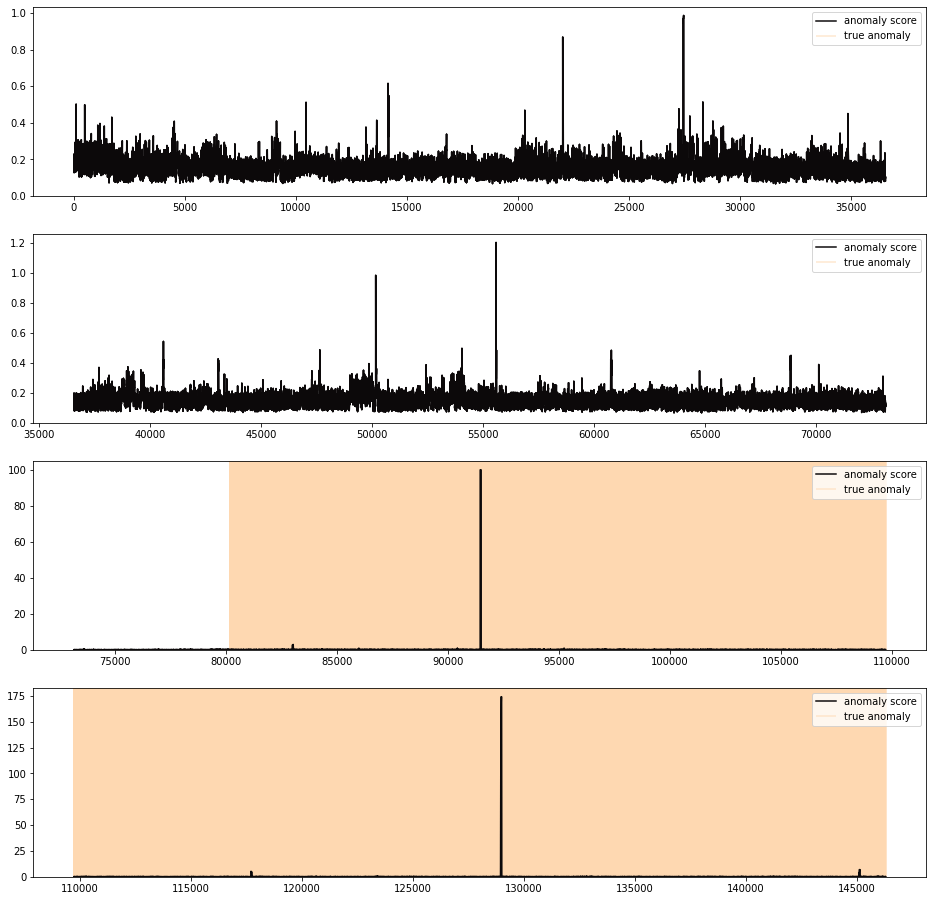

In [41]:
check_score_graph(anomaly_scores, labels, 4)
plt.show()

### STEP 7. Evaluation

In [42]:
# 성능 메트릭 계산 함수
def metric(y_true, y_pred, beta=2):
    precision = precision_score(y_true, y_pred)  # 정밀도 계산
    recall = recall_score(y_true, y_pred)  # 재현율 계산
    f2_score = fbeta_score(y_true, y_pred, beta=beta)  # F2 점수 계산
    
    return [f2_score, precision, recall]  # 계산된 성능 메트릭 반환


# 완전 탐색을 통해 최적의 threshold을 찾는 함수
def bf_search(score, label, start, end=None, step_num=1, display_freq=1, verbose=True):
    # 탐색 범위 설정
    if step_num is None or end is None:
        end = start
        step_num = 1
    search_step, search_range, search_lower_bound = step_num, end - start, start
    
    # 탐색 범위 출력
    if verbose:
        print("search range: ", search_lower_bound, search_lower_bound + search_range)
    
    thresholds = np.linspace(start, end, step_num)
    m = [-1., -1., -1.] # 최대 F1 score와 관련 메트릭 초기화
    m_t = 0.0 # 최적 threshold 초기화
    
    for threshold in thresholds:
        pred = np.where(score>=threshold, 1, 0)
        target = metric(label, pred)
        
        # 최고의 F1 score 업데이트
        if target[0] > m[0]:
            m_t = threshold
            m = target
            
        # 현재 탐색 상황 출력
        if verbose and i % display_freq == 0:
            print("cur thr: ", threshold, target, m, m_t)
    return m, m_t
    
# 성능 평가 함수 정의
def evaluation(score, 
               y_true, 
               start, 
               end=None, 
               step_num=1, 
               display_freq=1, 
               verbose=False, 
               threshold=None):
    
    
    # 임계값이 지정되지 않았으면 탐색 방법에 따라 최적의 임계값을 찾음
    if threshold is None:
        results, threshold = bf_search(score, 
                                       y_true, 
                                       start, 
                                       end, 
                                       step_num, 
                                       display_freq, 
                                       verbose)
    
    # 예측값 생성
    y_pred = np.where(serial_avg_scores>=threshold, 1, 0)
    # 이상치에 대한 F2 점수, 정밀도, 재현율 계산
    [f2_score, precision, recall] = metric(y_true, y_pred)
    
    # 평가 결과 출력
    print(f'[F2-score]: {f2_score:.4f}, [Precision]: {precision:.4f}, [Recall]: {recall:.4f}, [Threshold]: {threshold:.4f}')
    
    return f2_score, threshold

In [43]:
# 각 serial 번호와 label의 쌍을 고유하게 추출하여 정수 형태로 변환
serial_label_pairs = np.unique(np.column_stack((serial_nums, labels)), axis=0).astype(np.int32)
# 각 serial 번호에 대한 평균 anomaly score를 계산 (max 계산 시 mean 대신에 max)
serial_avg_scores = np.array([anomaly_scores[serial_nums == serial].mean() for serial, _ in serial_label_pairs])

# 성능 평가를 수행
f2_score, threshold1 = evaluation(serial_avg_scores, 
                                 serial_label_pairs[:, 1],  # label만 추출
                                 start=min(serial_avg_scores),  # 시작 threshold는 평균 점수의 최솟값
                                 end=np.percentile(serial_avg_scores, 99),  # 끝 threshold는 평균 점수의 99백분위수
                                 step_num=1000,  # 탐색할 threshold의 개수
                                 display_freq=100,  # 진행 상황을 표시할 빈도
                                 verbose=False)  # 진행 상황을 표시하지 않음

[F2-score]: 0.8147, [Precision]: 0.4844, [Recall]: 0.9822, [Threshold]: 0.1193


In [44]:
# 찾은 threshold에 대한 confusion matrix 결과
tn, fp, fn, tp = confusion_matrix(serial_label_pairs[:, 1], np.where(serial_avg_scores>=threshold1, 1, 0)).ravel()
(tn, fp, fn, tp)

(181, 1584, 27, 1488)

---